In [1]:
import os

import pickle

import mne
import torch
import torch.fft as fft

import numpy as np

import scipy.io
import scipy
import scipy.signal

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import re
import multiprocessing

from collections import Counter

In [2]:
def plot_psd(data, subject=0, channel=0, fs=100):
    x_t = data[subject][channel]

    N = x_t.shape[-1]
    t = torch.arange(0, N) * 1/fs

    plt.figure(figsize=(15, 4))

    plt.subplot(211)
    plt.plot(t, x_t)
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')

    plt.subplot(212)
    plt.psd(x_t, 1024, fs)
    plt.xlabel('f [Hz]')

    plt.tight_layout()
    plt.show()

### Check processed data

In [16]:
file_path = "/home/oturgut/data/TUAB/v3.0.1/edf/processed/train/"
subject = "aaaaammt_s001_t001_9.pkl"

file = open(file_path+subject, "rb")
pkl_object = pickle.load(file)

pkl_object

{'X': array([[-0.15405851, -0.16927558, -0.24644626, ...,  0.22795374,
          0.18848029,  0.19130688],
        [-0.42833535, -0.4541395 , -0.6351431 , ...,  0.461496  ,
          0.3899583 ,  0.2933985 ],
        [ 0.03043047, -0.02361476, -0.03052858, ...,  0.06402046,
          0.00678188,  0.05908482],
        ...,
        [-0.02607385, -0.00720218, -0.08531679, ...,  0.09862193,
          0.09527032,  0.0769331 ],
        [ 0.06724524,  0.03715312, -0.00361652, ...,  0.02560896,
          0.03698487,  0.01512681],
        [ 0.3872096 ,  0.1560378 , -0.07200999, ..., -0.36388438,
         -0.31748827, -0.29590428]]),
 'y': 0}

In [34]:
print(pkl_object["X"].shape, pkl_object["X"].dtype)
print(pkl_object["y"])
label = torch.nn.functional.one_hot(torch.tensor(pkl_object["y"]), num_classes=2).to(torch.int32)
print(label.dtype)

(19, 2000) float64
1
torch.int32


In [5]:
pkl_object["X"].mean(), pkl_object["X"].std() 

(0.036107891062545965, 0.6559692362421299)

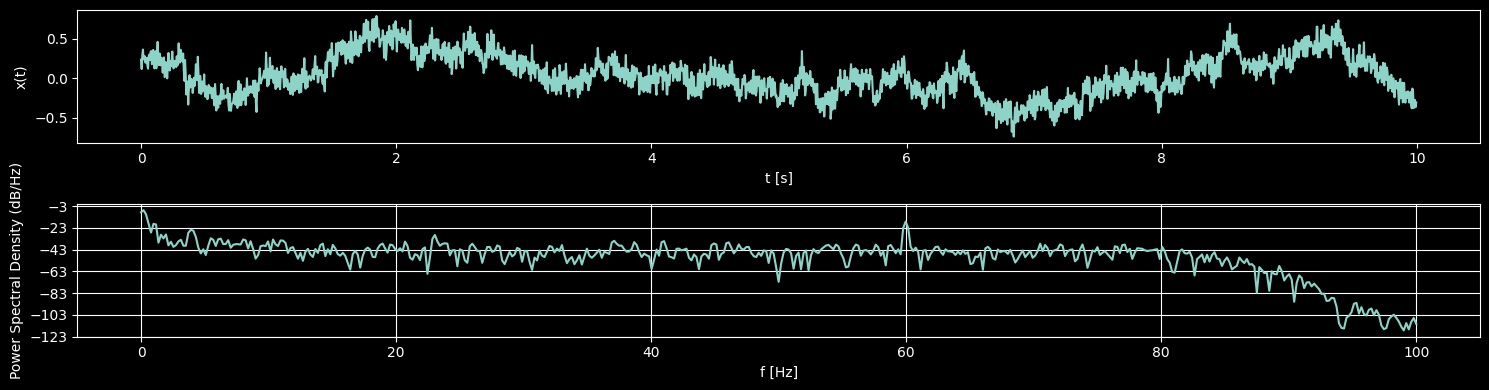

In [6]:
subject = 0
channel = 12
fs = 200
plot_psd(pkl_object["X"][None, ...], subject=subject, channel=channel, fs=fs)

### Convert processed data into correct format

In [3]:
def list_files(rootdir, file_format=".edf"):
    files = []
    for file in os.listdir(rootdir):
        curr_object = os.path.join(rootdir, file)
        if os.path.isdir(curr_object): 
            files += list_files(curr_object)
        elif file_format in curr_object:
            files.append(curr_object)

    return files

In [4]:
data_path_train = '/home/oturgut/data/TUAB/v3.0.1/edf/processed/train'
data_path_val = '/home/oturgut/data/TUAB/v3.0.1/edf/processed/val'
data_path_test = '/home/oturgut/data/TUAB/v3.0.1/edf/processed/test'

In [5]:
files_train = list_files(data_path_train, ".pkl")
files_val = list_files(data_path_val, ".pkl")
files_test = list_files(data_path_test, ".pkl")

In [6]:
print(len(files_train))
print(len(files_val))
print(len(files_test))

302524
69614
36945


In [7]:
302524+69614+36945

409083

In [8]:
def get_data_and_label(file_path):
    file = open(file_path, "rb")
    pkl_object = pickle.load(file)

    data = pkl_object["X"]
    label = pkl_object["y"]

    return data, label

In [9]:
if __name__ == "__main__":
    num_processes = 32
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = list(pool.map(get_data_and_label, files_val))

    # Extract results into separate lists
    data_raw, labels_raw = zip(*results)

    data = [("eeg_10-20", torch.tensor(sample, dtype=torch.float32)) for sample in data_raw]
    labels = torch.nn.functional.one_hot(torch.tensor(labels_raw), num_classes=2).to(torch.int32)

In [ ]:
data[0][1].shape

In [10]:
len(data)

69614

In [15]:
files_test[2]

'/home/oturgut/data/TUAB/v3.0.1/edf/processed/test/aaaaajna_s001_t000_51.pkl'

In [12]:
labels

tensor([[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.int32)

In [11]:
# torch.save(data, "/home/oturgut/data/processed/TUAB/val/data.pt")
# torch.save(labels, "/home/oturgut/data/processed/TUAB/val/labels.pt")

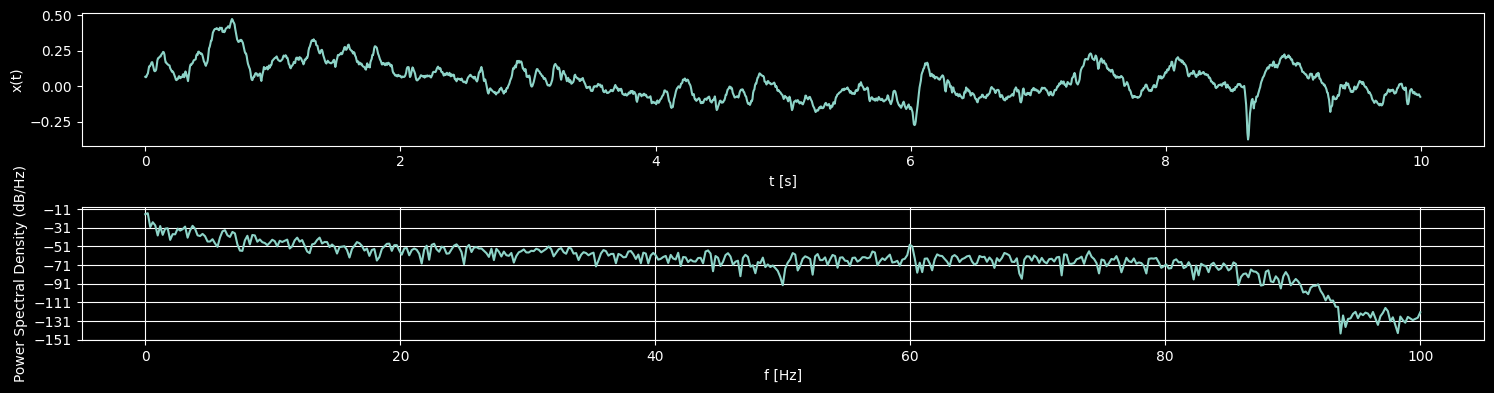

In [48]:
subject = 0
channel = 12
fs = 200
plot_psd(data[11000][1][None, ...], subject=subject, channel=channel, fs=fs)

### Parse the header file

In [2]:
data_path = '/home/oturgut/data/TUAB/v3.0.1/edf/train/normal/01_tcp_ar'

In [5]:
files = list_files(data_path)

In [6]:
len(files)

1371

In [10]:
raw = mne.io.read_raw_edf(files[3], verbose=False)
raw.ch_names

['EEG FP1-REF',
 'EEG FP2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'EEG FZ-REF',
 'EEG CZ-REF',
 'EEG PZ-REF',
 'EEG ROC-REF',
 'EEG LOC-REF',
 'EEG EKG1-REF',
 'EEG T1-REF',
 'EEG T2-REF',
 'PHOTIC-REF',
 'IBI',
 'BURSTS',
 'SUPPR']

In [11]:
raw.info

Measurement date,"January 01, 2012 00:00:00 GMT"
Experimenter,Unknown
Participant,aaaaaeqq
Digitized points,Not available
Good channels,30 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [4]:
# Flatten the list of lists
flat_channel_names = [channel for subject_channels in channel_names for channel in subject_channels]

# Use Counter to get unique channel names and their counts
channel_counts = Counter(flat_channel_names)

# List with the most occuring (i.e. > 0.8*len(channel_names)) channel names
most_common_channels = []

# Print unique channel names and their counts
for channel, count in channel_counts.items():
    # print(f"{channel}: {count} occurrences")
    if count > 69000: # (len(channel_names)*0.8):
        most_common_channels.append(channel)

print(len(most_common_channels))
print(most_common_channels)

19
['FP1', 'FP2', 'CZ', 'FZ', 'T3', 'F3', 'F4', 'O2', 'P4', 'O1', 'C3', 'P3', 'F7', 'PZ', 'T4', 'F8', 'C4', 'T5', 'T6']


### Create the raw dataset

In [5]:
len(file_paths)

69387

In [6]:
def extract_channels_and_waveform(edf_filename):
    # Extract subject ID from the file name
    subject_id = re.search(r'/([^/]+)\.edf', edf_filename).group(1)

    sampling_frequency = 250 # Hz
    tmin = 20   # seconds
    tmax = 80   # seconds

    try:
        # Read the EEG data from the .edf file
        raw = mne.io.read_raw_edf(edf_filename, verbose=False)

        # Get the selected channels and their indices
        selected_channels = [channel for channel in raw.ch_names if re.findall(r'EEG\s+([^-\s]+)-', channel) and re.findall(r'EEG\s+([^-\s]+)-', channel)[0] in most_common_channels]

        if len(selected_channels) >= len(most_common_channels):
            picks = raw.pick(selected_channels, verbose=False).crop(tmin=tmin, tmax=tmax, verbose=False).load_data(verbose=False).resample(sfreq=sampling_frequency, verbose=False)

            # Convert the data to a PyTorch tensor
            waveform_tensor = torch.tensor(picks._data)

            return subject_id, waveform_tensor, selected_channels, edf_filename
            # return subject_id, None, selected_channels, edf_filename
        else:
            return subject_id, None, "Not all channels exist", edf_filename
            # return subject_id, None, None, edf_filename

    except Exception as e:
        return subject_id, None, str(e), edf_filename
        # return subject_id, None, None, edf_filename

if __name__ == "__main__":
    num_processes = 32
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = list(pool.map(extract_channels_and_waveform, file_paths[:17500]))

    # Collect the results into a dictionary
    # data_dict = {result[0]: (result[1], result[2]) for result in results}
    data_dict = {result[0]: (result[1], result[2], result[3]) for result in results if result[1] is not None}
    # torch.save(data_dict, "/home/oturgut/data/processed/tuh/data_dict.pt")

In [7]:
len(data_dict)

13076

In [11]:
data_tensor = torch.stack([result[1] for result in results if result[1] is not None], dim=0)
print(data_tensor.shape)
# torch.save(data_tensor, "/home/oturgut/data/processed/tuh/250Hz/data_raw.pt")

In [12]:
labels_tensor = [labels_dict[subj_id][0] for subj_id in data_dict.keys()]
print(len(labels_tensor))
# torch.save(labels_tensor, "/home/oturgut/data/processed/tuh/labels_raw.pt")

13076


### Create the data split

In [52]:
# my_data = torch.load("/home/oturgut/data/processed/tuh/data_raw.pt")
# labels = torch.load("/home/oturgut/data/processed/tuh/labels_raw.pt")

In [13]:
# Save the subject ids in a list
all_subject_ids = [key.split("_")[0] for key in data_dict.keys()]

# Use Counter to get unique subject ids and their counts
subject_counts = Counter(all_subject_ids)

# Print unique subject ids and their counts
unique_subject_ids = {}
for channel, count in subject_counts.items():
    unique_subject_ids[channel] = count

Create data split

In [14]:
total_nb_samples = len(data_dict)

train_subject_ids, train_count = [], 0
val_subject_ids, val_count = [], 0
test_subject_ids, test_count = [], 0

total_count = 0
for subj_id, count in unique_subject_ids.items():
    if total_count >= 0.85*total_nb_samples:
        # test 15 %
        test_subject_ids.append(subj_id)
        test_count += count
    elif total_count >= 0.7*total_nb_samples:
        # val 15 %
        val_subject_ids.append(subj_id)
        val_count += count
    else:
        # train 70 %
        train_subject_ids.append(subj_id)
        train_count += count
    
    total_count += count

print(total_count)

13076


In [15]:
print(len(train_subject_ids), train_count)
print(len(val_subject_ids), val_count)
print(len(test_subject_ids), test_count)

3186 9155
900 1961
824 1960


Create the data and labels list

In [16]:
data_train, labels_train = [], []
data_val, labels_val = [], []
data_test, labels_test = [], []

for key, value in data_dict.items():
    subj_id = key.split("_")[0]

    if subj_id in train_subject_ids:
        data_train.append(value[0])
        labels_train.append(labels_dict[key][0])
    elif subj_id in val_subject_ids:
        data_val.append(value[0])
        labels_val.append(labels_dict[key][0])
    elif subj_id in test_subject_ids:
        data_test.append(value[0])
        labels_test.append(labels_dict[key][0])

In [17]:
print(len(data_train), len(labels_train))
print(len(data_val), len(labels_val))
print(len(data_test), len(labels_test))

9155 9155
1961 1961
1960 1960


Create the data tensors

In [21]:
data_train_tensor = torch.stack(data_train, dim=0)
data_val_tensor = torch.stack(data_val, dim=0)
data_test_tensor = torch.stack(data_test, dim=0)

In [22]:
print(data_train_tensor.shape)
print(data_val_tensor.shape) 
print(data_test_tensor.shape)

torch.Size([9155, 19, 15000])
torch.Size([1961, 19, 15000])
torch.Size([1960, 19, 15000])


In [23]:
# torch.save(data_train_tensor, "/home/oturgut/data/processed/tuh/data_raw_train.pt")
# torch.save(data_val_tensor, "/home/oturgut/data/processed/tuh/data_raw_val.pt")
# torch.save(data_test_tensor, "/home/oturgut/data/processed/tuh/data_raw_test.pt")

Create the label tensors

In [18]:
labels_train_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_train], dim=0).unsqueeze(dim=-1)
labels_val_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_val], dim=0).unsqueeze(dim=-1)
labels_test_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in labels_test], dim=0).unsqueeze(dim=-1)

In [19]:
print(labels_train_tensor.shape)
print(labels_val_tensor.shape) 
print(labels_test_tensor.shape)

torch.Size([9155, 1])
torch.Size([1961, 1])
torch.Size([1960, 1])


In [20]:
# torch.save(labels_train_tensor, "/home/oturgut/data/processed/tuh/labels_raw_train.pt")
# torch.save(labels_val_tensor, "/home/oturgut/data/processed/tuh/labels_raw_val.pt")
# torch.save(labels_test_tensor, "/home/oturgut/data/processed/tuh/labels_raw_test.pt")

### Process the data

Process the labels

In [21]:
labels_train_mean = labels_train_tensor.mean(dim=0, keepdim=True)
labels_train_std = labels_train_tensor.std(dim=0, keepdim=True)

print(labels_train_tensor.mean(dim=0), labels_train_tensor.std(dim=0))
print(labels_val_tensor.mean(dim=0), labels_val_tensor.std(dim=0))
print(labels_test_tensor.mean(dim=0), labels_test_tensor.std(dim=0))

tensor([48.4979]) tensor([20.0135])
tensor([51.7884]) tensor([20.9761])
tensor([53.9046]) tensor([20.5912])


In [22]:
labels_train_stdNormed = (labels_train_tensor - labels_train_mean) / labels_train_std
labels_val_stdNormed = (labels_val_tensor - labels_train_mean) / labels_train_std
labels_test_stdNormed = (labels_test_tensor - labels_train_mean) / labels_train_std

In [23]:
print(labels_train_stdNormed.shape)
print(labels_val_stdNormed.shape)
print(labels_test_stdNormed.shape)

torch.Size([9155, 1])
torch.Size([1961, 1])
torch.Size([1960, 1])


In [24]:
print(labels_train_stdNormed.min(), labels_train_stdNormed.max(), labels_train_stdNormed.mean(), labels_train_stdNormed.std())
print(labels_val_stdNormed.min(), labels_val_stdNormed.max(), labels_val_stdNormed.mean(), labels_val_stdNormed.std())
print(labels_test_stdNormed.min(), labels_test_stdNormed.max(), labels_test_stdNormed.mean(), labels_test_stdNormed.std())

tensor(-2.3733) tensor(2.8232) tensor(-6.7710e-08) tensor(1.)
tensor(-2.3733) tensor(2.8732) tensor(0.1644) tensor(1.0481)
tensor(-2.3733) tensor(3.4228) tensor(0.2702) tensor(1.0289)


In [25]:
# torch.save(labels_train_stdNormed, "/home/oturgut/data/processed/tuh/labels_train_stdNormed.pt")
# torch.save(labels_val_stdNormed, "/home/oturgut/data/processed/tuh/labels_val_stdNormed.pt")
# torch.save(labels_test_stdNormed, "/home/oturgut/data/processed/tuh/labels_test_stdNormed.pt")

Processing

In [25]:
def plot_psd(data, subject=0, channel=0, fs=100):
    x_t = data[subject][channel]

    N = x_t.shape[-1]
    t = torch.arange(0, N) * 1/fs

    plt.figure(figsize=(15, 4))

    plt.subplot(211)
    plt.plot(t, x_t)
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')

    plt.subplot(212)
    plt.psd(x_t, 1024, fs)
    plt.xlabel('f [Hz]')

    plt.tight_layout()
    plt.show()

In [26]:
def filter(data, fs=100, order=10, f_cutoff=45, btype='lp'):
    sos_filter = scipy.signal.butter(order, f_cutoff, btype=btype, fs=fs, output='sos')
    data_filtered = scipy.signal.sosfilt(sos_filter, data)

    return torch.tensor(data_filtered, dtype=torch.float32)

In [27]:
def normalize(data):
    mean = torch.mean(data, dim=-1, keepdim=True)
    var = torch.var(data, dim=-1, keepdim=True)

    data_normalized = (data - mean) / (var + 1.e-12)**.5

    return data_normalized

In [28]:
def clamp(data, min=-3, max=3):
    return torch.clamp(data, min=min, max=max)

In [90]:
data_filtered_lp = filter(data_train_tensor, fs=100, order=10, f_cutoff=35, btype='lp')
data_filtered_lp_hp = filter(data_filtered_lp, fs=100, order=10, f_cutoff=15, btype='hp')
data_normalized = normalize(data_filtered_lp_hp)
data_clamped = clamp(data_normalized)

In [ ]:
# torch.save(data_clamped, "/home/oturgut/data/processed/tuh/data_train.pt")
# torch.save(data_clamped, "/home/oturgut/data/processed/tuh/data_val.pt")
# torch.save(data_clamped, "/home/oturgut/data/processed/tuh/data_test.pt")

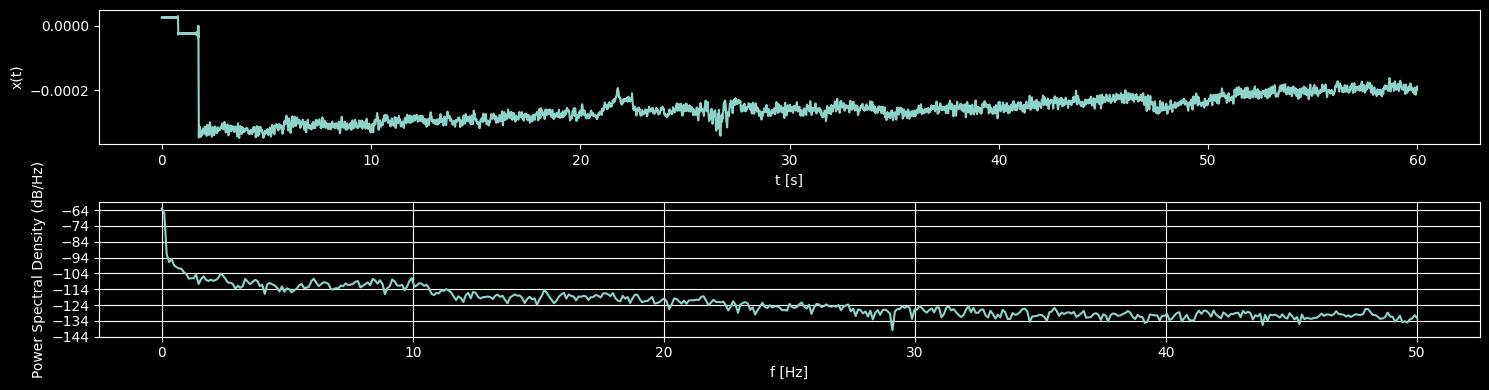

In [91]:
subject = 0
channel = 18
fs = 100
plot_psd(data_val_tensor, subject=subject, channel=channel, fs=fs)

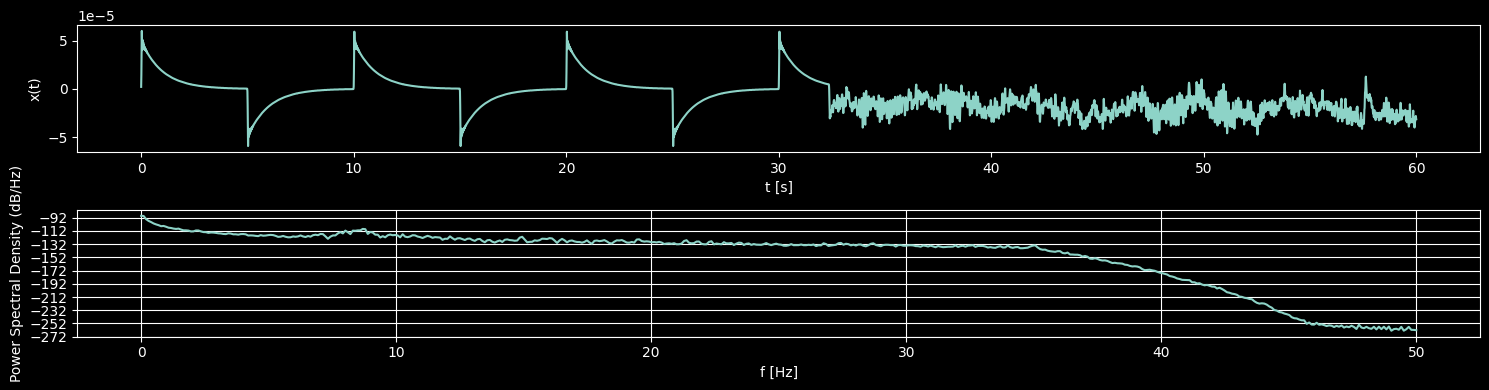

In [92]:
plot_psd(data_filtered_lp, subject=subject, channel=channel, fs=fs)

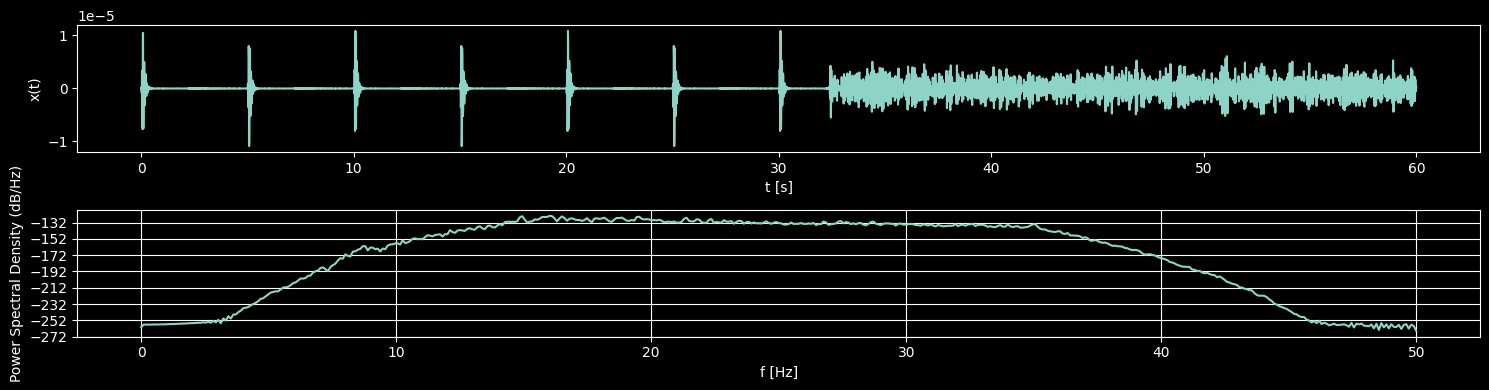

In [93]:
plot_psd(data_filtered_lp_hp, subject=subject, channel=channel, fs=fs)

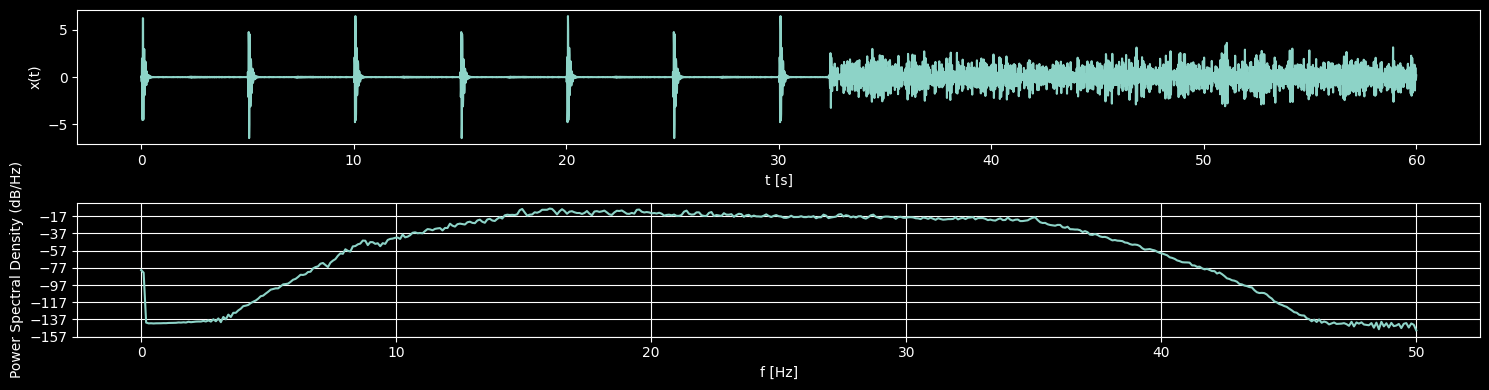

In [94]:
plot_psd(data_normalized, subject=subject, channel=channel, fs=fs)

In [42]:
data_normalized = normalize(data_test_tensor)
data_clamped = clamp(data_normalized)

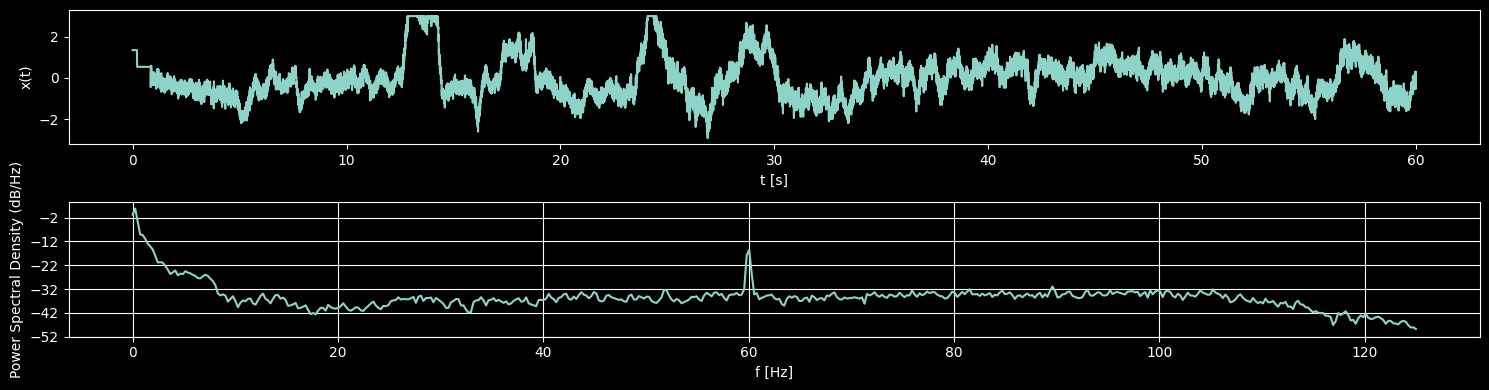

In [43]:
plot_psd(data_clamped, subject=subject, channel=channel, fs=fs)

In [19]:
labels_train_tensor[subject]

tensor([58.])

In [ ]:
# def process_ecgs(sample):
#     # low pass filter
#     data = filter(data, fs=100, order=10, f_cutoff=45, btype='lp')

#     # high pass filter
#     data = filter(data, fs=100, order=10, f_cutoff=0.5, btype='hp')

#     # normalize data
#     data = normalize(sample)

#     # clamp data
#     data = clamp(data)

#     return data


# if __name__ == '__main__':
#     # Define the number of processes
#     num_processes = 32

#     # Create a multiprocessing Pool
#     with multiprocessing.Pool(processes=num_processes) as pool:
#         data_processed = list(pool.map(process_ecgs, data_train_tensor))

Analysis

In [ ]:
# data_train_tensor = torch.load("/home/oturgut/data/processed/tuh/data_raw_train.pt")
# data_val_tensor = torch.load("/home/oturgut/data/processed/tuh/data_raw_val.pt")
data_test_tensor = torch.load("/home/oturgut/data/processed/tuh/data_test.pt")

In [ ]:
def time2frequency(sample, factor=1, return_half=False, unsqueeze=True):
    sample_dims = sample.dim()

    # define the output length of the Fourier transform
    N = factor * sample.shape[-1] 
    
    # perform the Fourier transform and reorder the output to have negative frequencies first
    # note: the output of the Fourier transform is complex (real + imaginary part)
    X_f = 1/N * fft.fftshift(fft.fft(sample, n=N))

    X_f_complex = torch.Tensor()

    if unsqueeze == False:
        # if you want real and imag part to be concatenated 
        # such that the output has shape [ch*2, time_steps]
        if sample_dims == 2:
            for ch in range(X_f.shape[0]):
                real_part = torch.real(X_f[ch, :]).unsqueeze(dim=0)
                imag_part = torch.imag(X_f[ch, :]).unsqueeze(dim=0)

                # concatenate the real and imaginary parts 
                complex_pair = torch.cat((real_part, imag_part), dim=0)

                # concatenate the channels 
                X_f_complex = torch.cat((X_f_complex, complex_pair), dim=0)
        elif sample_dims == 3:
            for bin in range(X_f.shape[0]):
                X_f_bin_complex = torch.Tensor()
                
                for ch in range(X_f.shape[1]):
                    real_part = torch.real(X_f[bin, ch, :]).unsqueeze(dim=0)
                    imag_part = torch.imag(X_f[bin, ch, :]).unsqueeze(dim=0)

                    # concatenate the real and imaginary parts 
                    complex_pair = torch.cat((real_part, imag_part), dim=0)#.unsqueeze(dim=0)

                    # concatenate the channels
                    X_f_bin_complex = torch.cat((X_f_bin_complex, complex_pair), dim=0)

                # concatenate the frequency bins
                X_f_complex = torch.cat((X_f_complex, X_f_bin_complex.unsqueeze(dim=0)), dim=0)
    else:
        # if you want real and imag part to be concatenated 
        # such that the output has shape [2, ch, time_steps]
        X_f_complex = X_f.unsqueeze(dim=-3)
        X_f_real = torch.real(X_f_complex)
        X_f_imag = torch.imag(X_f_complex)

        X_f_complex = torch.cat((X_f_real, X_f_imag), dim=-3)

    # note: the Fourier transform of a signal with only real parts is symmetric 
    #       thus only half of the transform can be returned to save memory
    start_idx = 0
    if return_half == True:
        start_idx = int(N/2)
    
    return X_f_complex[..., start_idx:]

In [ ]:
fs = 250 # sampling frequency

# data in time domain
subject = 1
channel = 10
x_t = data_test_tensor[subject][channel][-100:]

N = len(x_t)
t = torch.arange(0, N) * 1/fs

# data in frequency domain
Y = fft.fftshift(fft.fft(x_t))

N = len(x_t)
f = torch.arange(-N/2, N/2) * 1/N * fs # symmetric + normalized + appyling correct fs
f_half = torch.arange(0, N/2) * 1/N * fs # symmetric + normalized + appyling correct fs

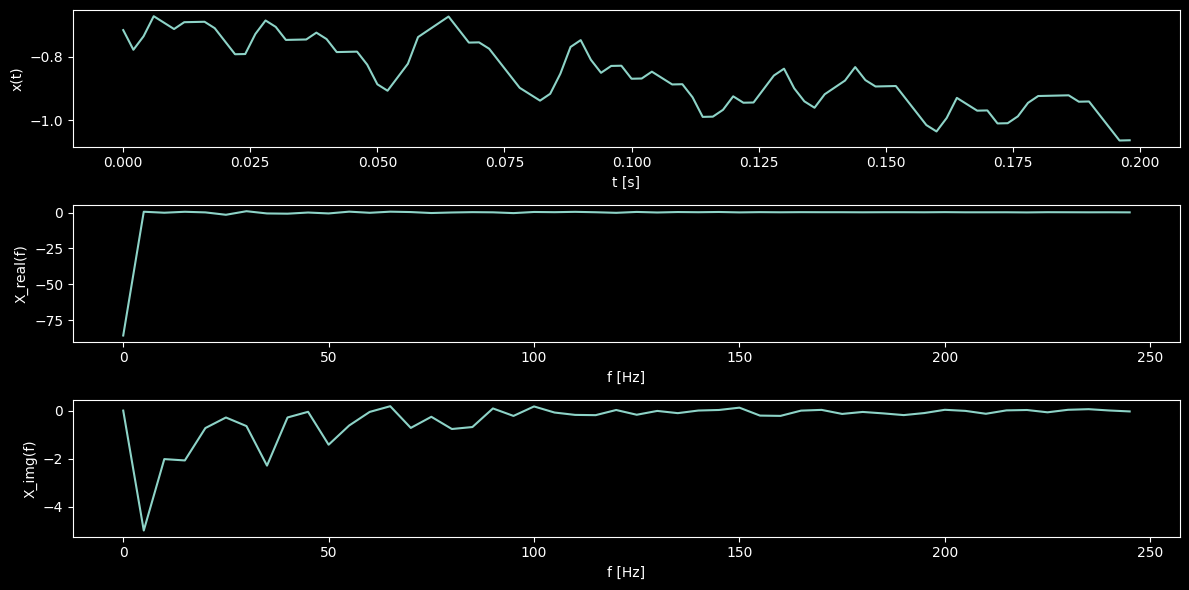

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(311)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(312)
plt.plot(f_half, torch.real(Y)[..., int(Y.shape[-1]/2):])
plt.xlabel('f [Hz]')
plt.ylabel('X_real(f)')

plt.subplot(313)
plt.plot(f_half, torch.imag(Y)[..., int(Y.shape[-1]/2):])
plt.xlabel('f [Hz]')
plt.ylabel('X_img(f)')

# plt.subplot(414)
# plt.plot(t, torch.real(fft.ifft(fft.ifftshift(Y))))
# plt.xlabel('t [s]')
# plt.ylabel('x(t)')

plt.tight_layout()
plt.show()